# Keras 
 - 前走のデータを使った予測モデル
 - 3着までを1、それ以外を0とした2値分類

In [16]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold,KFold
from sklearn.preprocessing import StandardScaler

from sklearn import metrics

from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

#GPUメモリの制御
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for k in range(len(physical_devices)):
        tf.config.experimental.set_memory_growth(physical_devices[k], True)
        print('memory growth:', tf.config.experimental.get_memory_growth(physical_devices[k]))
else:
    print("Not enough GPU hardware devices available")

memory growth: True


In [17]:
#データの読み込み
df = pd.read_csv("../../data/baseline_data.csv")
df_past2 = df[(df["past_race_num"]==2)]

In [18]:
#最低限の前処理
df_past2 = df_past2.fillna({'past_dif_time1': 0, 'past_dif_time2': 0})
df_past2 = df_past2.dropna(how='any')
columns = ["pred_horse_sex",
          "pred_race_rank1",
          "pred_race_rank2",
          "pred_kind",
          "pred_distance",
          "pred_condition",
          "pred_place",
          "past_horse_sex",
          "past_race_rank1",
          "past_race_rank2",
          "past_distance",
          "past_kind",
          "past_condition",
          "past_place"]
df_past2 = pd.get_dummies(df_past2, drop_first=True, columns=columns)
#target
df_past2["target"] = df_past2.pred_tyaku.apply(lambda x : 1 if x < 4 else 0)

In [19]:
learn_data = df_past2.sample(frac=1,random_state=1)
scaler = StandardScaler()

X          = learn_data.iloc[:,4:-1].values
X          = scaler.fit_transform(X)
y          = learn_data.target.values
x_columns  = learn_data.iloc[:,4:-1].columns

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,stratify=y,random_state=1)

In [20]:
#model
def create_model(optimizer='adam',init = 'glorot_normal',input_dim=None):
    model= Sequential()
    model.add(Dense(128,input_dim=input_dim,kernel_initializer=init,activation='relu'))
    model.add(Dense(256,kernel_initializer=init,activation='relu'))
    model.add(Dense(128,kernel_initializer=init,activation='relu'))
    model.add(Dense(64,kernel_initializer=init,activation='relu'))
    model.add(Dense(1, kernel_initializer=init,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    return model

In [21]:
model = create_model(input_dim = X.shape[1])

In [22]:
fit = model.fit(x=X_train,y=y_train,
         validation_data=(X_test,y_test),
         epochs=20,
         batch_size = 32,
         shuffle=True)

Train on 93700 samples, validate on 23425 samples
Epoch 1/20
93700/93700 [==============================] - 6s 62us/step - loss: 0.4960 - accuracy: 0.7787 - val_loss: 0.4888 - val_accuracy: 0.7794
Epoch 2/20
93700/93700 [==============================] - 6s 62us/step - loss: 0.4852 - accuracy: 0.7812 - val_loss: 0.4865 - val_accuracy: 0.7796
Epoch 3/20
93700/93700 [==============================] - 6s 62us/step - loss: 0.4806 - accuracy: 0.7828 - val_loss: 0.4861 - val_accuracy: 0.7801
Epoch 4/20
93700/93700 [==============================] - 6s 62us/step - loss: 0.4773 - accuracy: 0.7846 - val_loss: 0.4869 - val_accuracy: 0.7804
Epoch 5/20
93700/93700 [==============================] - 6s 62us/step - loss: 0.4733 - accuracy: 0.7864 - val_loss: 0.4873 - val_accuracy: 0.7796
Epoch 6/20
93700/93700 [==============================] - 6s 61us/step - loss: 0.4685 - accuracy: 0.7887 - val_loss: 0.4931 - val_accuracy: 0.7782
Epoch 7/20
93700/93700 [==============================] - 6s 61us/st

auc 0.6068783095636874


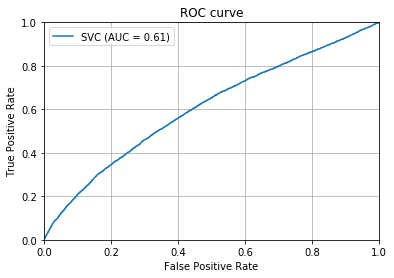

In [23]:
#auc
result_pred = model.predict(X_test)
auc = metrics.roc_auc_score(y_test, result_pred)
print("auc",auc)
fpr, tpr, thresholds = metrics.roc_curve(y_test, result_pred)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='SVC (AUC = %.2f)'%auc)
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

train (epoch:20/loss:0.32468928057457874)
test  (epoch:20/loss:0.7216435156904137)


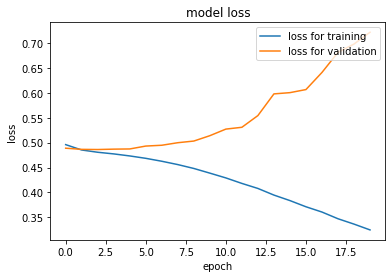

In [24]:
#loss
def loss_plot(train_loss,test_loss):
    print("train (epoch:{}/loss:{})" .format( str(len(train_loss)) , str(train_loss[-1])))
    print("test  (epoch:{}/loss:{})" .format( str(len(test_loss)) , str(test_loss[-1])))
    plt.figure()
    plt.plot(np.arange(0,len(train_loss)),train_loss,label="loss for training")
    plt.plot(np.arange(0,len(test_loss)),test_loss,label="loss for validation")

    plt.legend()
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()
#run
loss_plot(fit.history['loss'],fit.history['val_loss'])